In [1]:
import git
import os
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
repo_name = "palaute"

# check if the repository exists at ./tmp/repo_name
# if it does, pull the latest changes
# if it doesn't, clone the repository
def get_repo():
    if os.path.exists(f"./tmp/{repo_name}"):
        # Git pull the latest changes
        repo = git.Repo(f"./tmp/{repo_name}")
        repo.remotes.origin.pull()
        return repo
    else:
        # Git clone the repository into ./tmp
        url = f"https://github.com/UniversityOfHelsinkiCS/{repo_name}"
        return git.Repo.clone_from(url, f"./tmp/{repo_name}")
    
repo = get_repo()

In [3]:
from dataclasses import dataclass

@dataclass
class FileNode:
    name: str
    lines: int
    children: list = None

    def to_json(self):
        result = { "name": self.name }
        if self.children:
            result["children"] = [child.to_json() for child in self.children]
        else:
            result["lines"] = self.lines
        return result

# Find all files in the repository (./tmp/repo)
file_names = set()

acual_root_node = FileNode("/", 0, [])

dir_nodes = { "": acual_root_node }

prefix = f"./tmp/{repo_name}/"

for root, dirs, dir_files in os.walk(f"./tmp/{repo_name}/"):
    root_node = dir_nodes[root.removeprefix(prefix)]
    
    for file in dir_files:
        path = os.path.join(root, file)
        fname = path.removeprefix(prefix)
        
        # Count the number of lines in the file
        lines = 0
        with open(path, "r") as f:
            try:
                lines = len(f.readlines())
            except UnicodeDecodeError:
                print(f"UnicodeDecodeError: {fname}")

        fnode = FileNode(fname, lines)
        root_node.children.append(fnode)
        file_names.add(fname)
    if ".git" in dirs:
        dirs.remove(".git")
    
    for dir in dirs:
        dname = os.path.join(root, dir).removeprefix(prefix)
        dnode = FileNode(dname, 0, [])
        root_node.children.append(dnode)
        dir_nodes[dname] = dnode

# Save the file tree to JSON
import json
with open(f"./tmp/{repo_name}_file_tree.json", "w") as f:
    json.dump(acual_root_node, f, indent=2, default=lambda o: o.to_json())

UnicodeDecodeError: Tietosuojaseloste.pdf
UnicodeDecodeError: documentation/feature_drafts/opetukseni/opetukseni_suggestion.png
UnicodeDecodeError: documentation/feature_drafts/opetukseni/2024-02-02_12-11.png
UnicodeDecodeError: public/seal.gif
UnicodeDecodeError: public/seal.png
UnicodeDecodeError: public/favicon-32x32.png
UnicodeDecodeError: src/client/assets/norppa_holy_smoke.png


In [6]:
df = None

if os.path.exists(f"./tmp/{repo_name}_changes.csv"):
    df = pd.read_csv(f"./tmp/{repo_name}_changes.csv")
else:
    authors = set()
    source_files = set()
    changes = []

    for commit in repo.iter_commits('master'):
        authors.add(commit.author.name)

        for item in commit.stats.files:
            if item not in file_names:
                continue
            source_files.add(item)
            changes.append({
                'commit': commit.hexsha,
                'file': item,
                'insertions': commit.stats.files[item]['insertions'],
                'deletions': commit.stats.files[item]['deletions'],
                'author': commit.author.name,
                'date': commit.authored_datetime
            })
        
        print("#", end="")

    df = pd.DataFrame(changes)

    df.to_csv(f"./tmp/{repo_name}_changes.csv", index=False)


########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [7]:
adjacency_df = None

if os.path.exists(f"./tmp/{repo_name}_adjacency.csv"):
    adjacency_df = pd.read_csv(f"./tmp/{repo_name}_adjacency.csv", index_col=0)
else:
    file_idx = list(file_names)
    adjacency_df = pd.DataFrame(index=file_idx, columns=file_idx, dtype=np.int16)
    adjacency_df = adjacency_df.fillna(0)

    # Count the number of times each file is changed with each other file
    for fnames in df.groupby(df["commit"])["file"].apply(list):
        for file in fnames:
            for other_file in fnames:
                if file == other_file:
                    continue
                adjacency_df.loc[file, other_file] = adjacency_df.loc[file, other_file] + 1

    adjacency_df.to_csv(f"./tmp/{repo_name}_adjacency.csv")

In [72]:
adjacency_df.head()

,compose.ci.yaml,src/client/components/Banner/ShowMore.tsx,src/server/chatInstances/access.ts,src/client/components/Chat/util.ts,src/client/hooks/useUserCourses.ts,src/client/assets/hy_logo.svg,src/server/util/sentry.ts,src/server/index.ts,src/client/components/Chat/Status.tsx,src/client/hooks/usePromptMutation.ts,...,src/client/types.ts,src/server/middleware/shibboleth.ts,src/client/components/Course/Chat/Status.tsx,src/server/util/importer.ts,src/client/hooks/useChatInstanceUsage.ts,playwright.config.ts,src/client/components/Chat/index.tsx,src/server/db/migrations/20240309_00_add_total_usage_to_users.ts,src/client/components/NavBar/styles.ts,src/client/components/Admin/Usage/UserTable.tsx
compose.ci.yaml,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
src/client/components/Banner/ShowMore.tsx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
src/server/chatInstances/access.ts,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
src/client/components/Chat/util.ts,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,...,4.0,0.0,1.0,0.0,1.0,0.0,14.0,0.0,0.0,0.0
src/client/hooks/useUserCourses.ts,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0


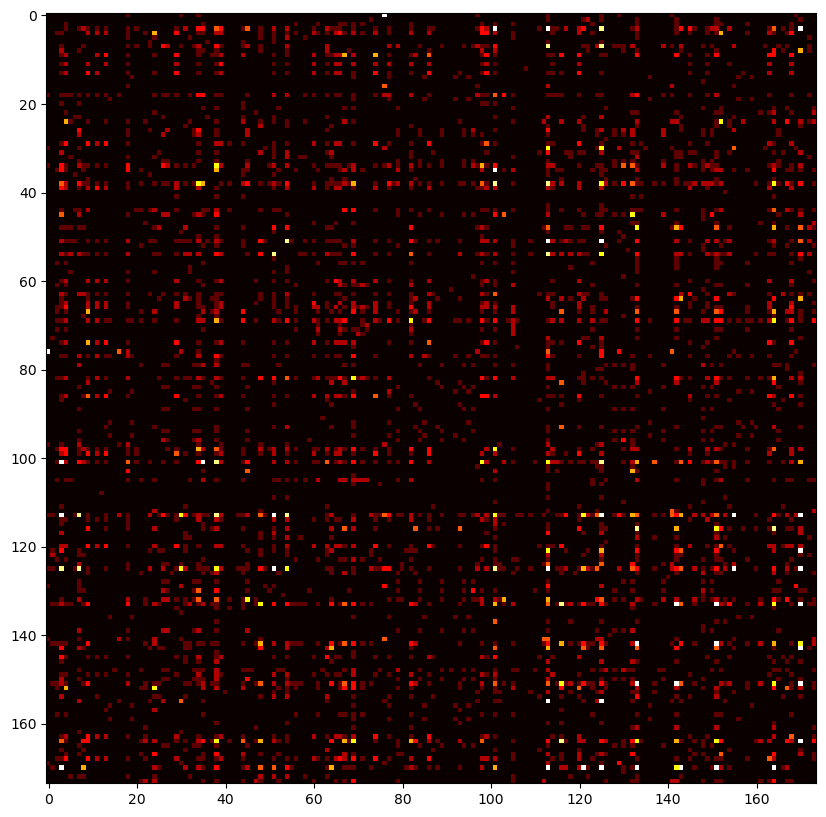

In [75]:
# Sort adjacency_df
plt.figure(figsize=(10,10))
plt.imshow(adjacency_df.values, cmap='hot', interpolation='nearest', vmax=8)

[0.25 0.25 0.25 ... 1.   0.25 0.25]


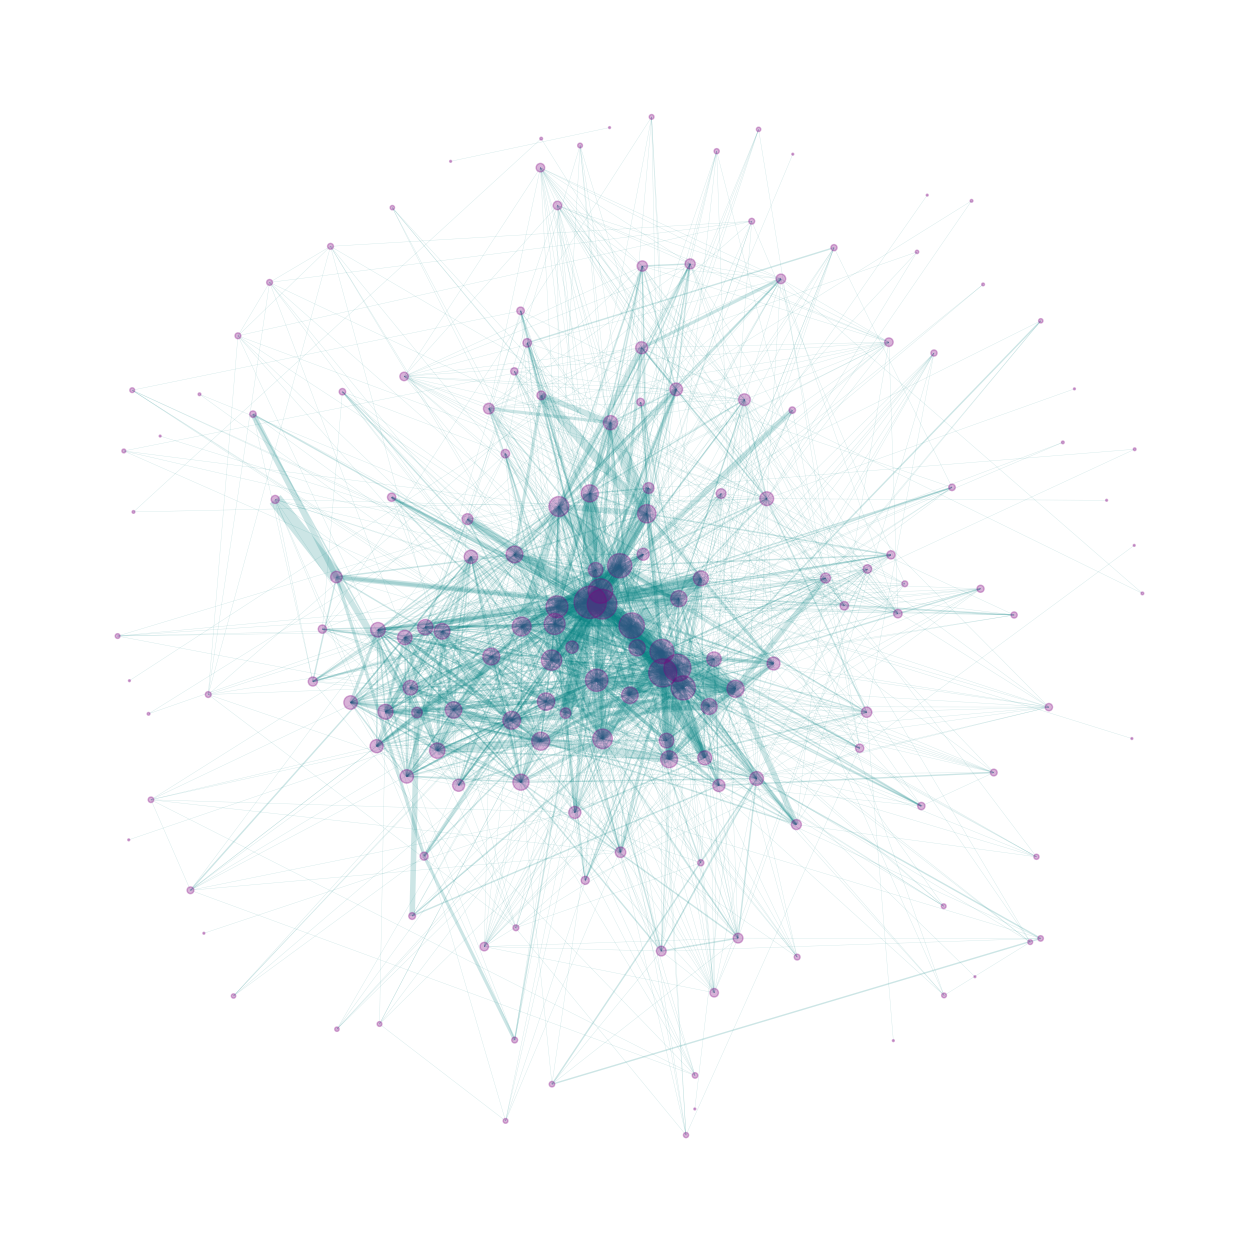

In [90]:
adjacency_df = adjacency_df
node_sizes = adjacency_df.sum(axis=1).mul(2)

graph = nx.from_pandas_adjacency(adjacency_df.mul(0.5).pow(2))

layout = nx.spring_layout(
    graph,
    k=0.7,
    seed=42,
    weight='weight',
    dim=2,
)

weights = np.fromiter(map(lambda x: x[2]['weight'], graph.edges(data=True)), dtype=np.float32)
print(weights)

fig, ax = plt.subplots()
fig.set_facecolor('white')

nx.draw_networkx_edges(graph, layout, 
    width=np.minimum(weights, 10),
    alpha=0.2,
    edge_color="teal",
    # edge_cmap=plt.colormaps["hot"],
    # edge_vmin=0,
    # edge_vmax=4,
    ax=ax
)

nx.draw_networkx_nodes(graph, layout,
    node_size=node_sizes,
    node_color='purple',
    alpha=0.3,
    ax=ax
)

# nx.draw_networkx_labels(graph, layout, font_size=6)

fig.set_size_inches(16, 16)
plt.axis('off')
plt.show()

In [91]:
layout = nx.kamada_kawai_layout(
    graph,
    weight='weight',
)

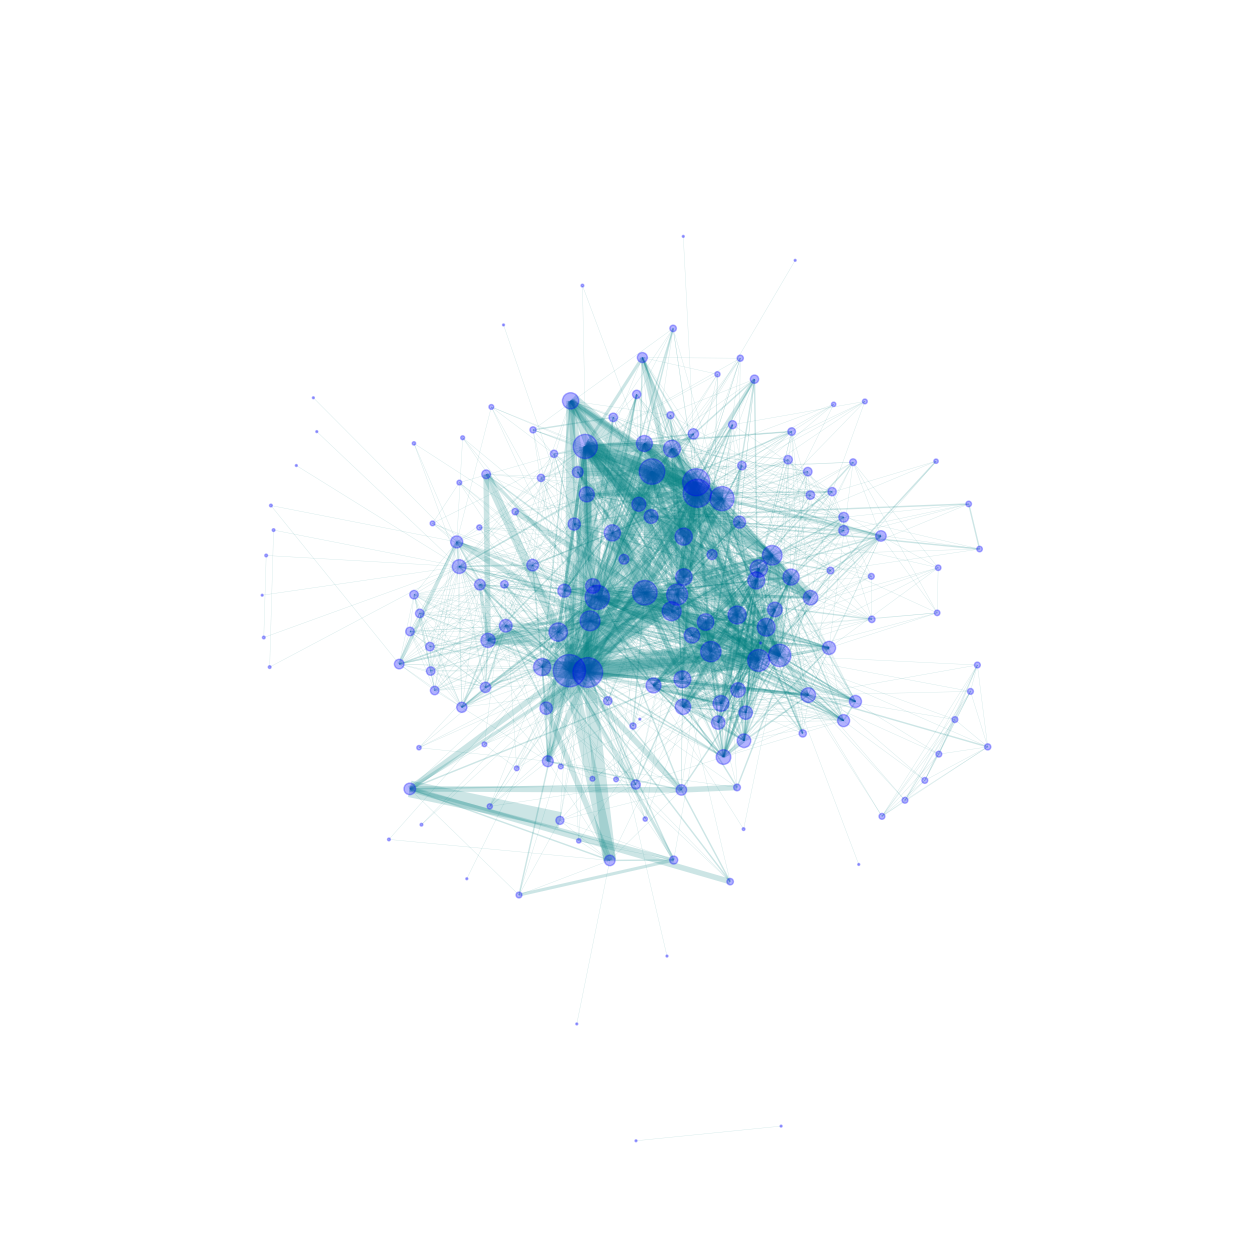

In [98]:
fig, ax = plt.subplots()
fig.set_facecolor('white')

nx.draw_networkx_edges(graph, layout,
    width=np.minimum(weights, 12),
    alpha=0.2,
    edge_color="teal",
    # edge_cmap=plt.colormaps["hot"],
    # edge_vmin=0,
    # edge_vmax=4,
    ax=ax
)

nx.draw_networkx_nodes(graph, layout,
    node_size=node_sizes,
    node_color='blue',
    alpha=0.3,
    ax=ax
)

# nx.draw_networkx_labels(graph, layout, font_size=6)

fig.set_size_inches(16, 16)
plt.axis('off')
plt.show()